In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.integrate as integrate
# from tqdm import tqdm  
import matplotlib.animation as anim

# Colisiones 2D de duración finita

In [55]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
    # Method
    def Evolution(self,i, ParticleList):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.CalculateForce(i, ParticleList)
        #self.SetAcceleration(i,self.a)
        
        # Euler method
        self.r += self.dt * self.v
        self.v += self.dt * self.a
    
    def CheckWallLimits(self,limits,dim=2):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = - self.v[i]
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = - self.v[i]
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    def SetAcceleration(self,i,a):
        self.aVector[i] = a
        
    # Getters  
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    

    def GetVelocityVector(self):
        return self.vVector
    
    def GetR(self):
        return self.radius
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
               # print(self.RrVector)
            
    def CalculateForce(self, i , ParticleList, K=100):
        force = np.zeros(len(self.r))
        for particle in ParticleList:
            if particle.Id != self.Id:
                norma = np.linalg.norm(self.r-particle.r)
                if norma<self.radius+particle.radius:
                    force = K*np.power(norma,2)*(self.r-particle.r)
        self.SetAcceleration(i,force/self.m)
        return force
            
    def GetKineticEnergy(self):
        kinenergy = 0.5*self.m*np.linalg.norm(self.v)**2
        return kinenergy
    
    def GetPotentialEnergy(self, particle, K):
        dr = self.r-particle.r
        rf = np.linalg.norm(dr)
        R1 = self.radius
        R2 = particle.radius
        R = R1 + R2
        if rf<R:
            integral = K*((R1+R2)**4-rf**4)/4
        else:
            integral = 0
        return integral

In [56]:
# Discretization
dt = 0.0001
tmax = 10
t = np.arange(0,tmax+dt,dt)
print(len(t))

100001


In [57]:
def GetParticles():
    ParticleList = []
    m= 1
    R= 2
    
    p1 = Particle(np.array([0.,0.]),np.array([20.,0.]),np.array([0.,0.]),t,m,R,1)
    p2 = Particle(np.array([0.,-1.6]),np.array([0.,0.]),np.array([0.,0.]),t,m,R,2)
    p3 = Particle(np.array([-15.,-15.]),np.array([0.,0.]),np.array([0.,0.]),t,m,R,3)
    
    ParticleList.append(p1)
    ParticleList.append(p2)
    ParticleList.append(p3)
    
    return ParticleList

In [58]:
def GetTotalPE(ParticleList):
    PE = 0
    K = 100
    for i in ParticleList:
        for j in ParticleList:
            PE+=i.GetPotentialEnergy(j,K)
    return PE/2

In [59]:
def GetTotalKE(ParticleList):
    KE = 0
    for i in ParticleList:
        KE += i.GetKineticEnergy()
    return KE

In [60]:
Limits = np.array([20.,20.])
def RunSimulation(t):
    Particles = GetParticles()
    PE = np.zeros(len(t))
    KE = np.zeros(len(t))
    for it in range(len(t)): # Evolucion temporal
        for i in range(len(Particles)):
            Particles[i].CheckWallLimits(Limits)
            Particles[i].Evolution(it, Particles)
        PE[it] = GetTotalPE(Particles)
        KE[it] = GetTotalKE(Particles)
        
        
    return Particles, PE, KE

In [ ]:
Particles, PE, KE = RunSimulation(t)

In [ ]:
plt.plot(t,PE, label='PE')
plt.plot(t,KE, label='KE')
plt.plot(t,PE+KE,label='PE+KE')
plt.legend()

In [51]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [52]:
redt = ReduceTime(t,10)
len(Particles[0].GetRPositionVector())

10001

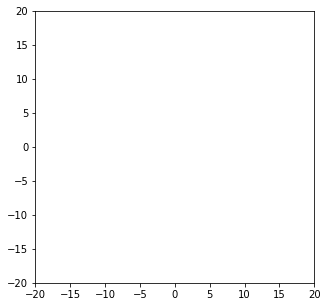

In [53]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetVelocityVector()[i,0]
        vy = p.GetVelocityVector()[i,1]
        
        circle = plt.Circle( (x,y), p.GetR(), color='k', fill=False)
        plot = ax.add_patch(circle)
        #plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

# Tiempo libre medio

(a) Descargue los datos:

In [10]:
!wget https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/EnergiaPotencialGas2D.txt

--2022-02-14 21:24:10--  https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/EnergiaPotencialGas2D.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400000 (391K) [text/plain]
Saving to: ‘EnergiaPotencialGas2D.txt’

EnergiaPotencialGas 100%[===================>] 390.62K   956KB/s    in 0.4s    

2022-02-14 21:24:12 (956 KB/s) - ‘EnergiaPotencialGas2D.txt’ saved [400000/400000]



In [11]:
E = []
t = []

with open('EnergiaPotencialGas2D.txt', 'r') as data:
    csv_reader = csv.reader(data, delimiter=' ')

    for line in csv_reader:
        t.append(float(line[0]))
        E.append(float(line[1]))

E = np.array(E)
t = np.array(t)

In [12]:
sampleT = t[1] - t[0]

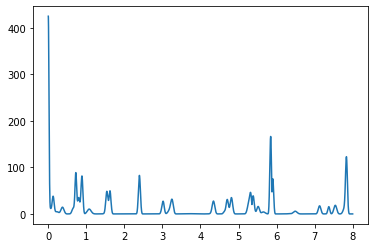

In [13]:
plt.plot(t,E)
plt.show()

(b) Quitar el valor medio de la energía potencial.

In [14]:
E_m = E - np.mean(E)

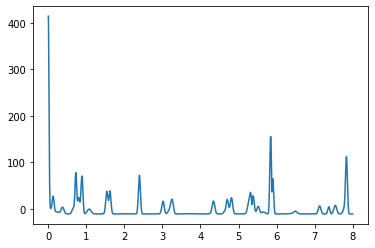

In [15]:
plt.plot(t,E_m)
plt.show()

(c) Encuentre la transformada rápida de Fourier de los datos.

In [16]:
X = np.fft.fft(E_m)
freqs = np.fft.fftfreq(len(t))

In [17]:
X_a = np.abs(X)

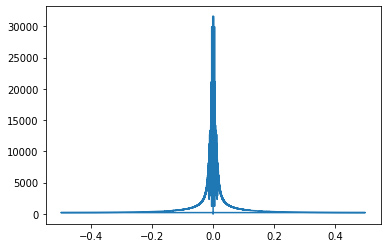

In [18]:
plt.plot(freqs,X_a)
plt.show()

(d) Encuentre la frecuencia fundamental asociada a la frecuencia media de colisión entre partículas.

In [19]:
mask = freqs < 0
X[mask] = 0
X_a[mask] = 0

In [20]:
ii = np.argmax(X_a)
mask = X_a < X_a[ii]
X[mask] = 0

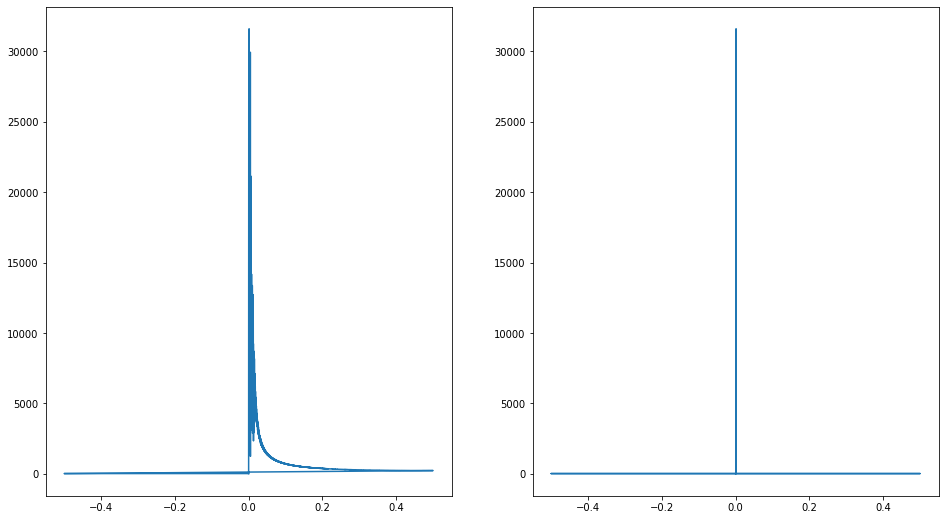

In [21]:
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.plot(freqs,X_a)

plt.subplot(1,2,2)
plt.plot(freqs,np.abs(X))
plt.show()

In [22]:
f0 = freqs[ii]
print(r'La frecuencia fundamental asociada a la frecuencia media de colisión es {:.4f} s^-1.'.format(f0/sampleT))

La frecuencia fundamental asociada a la frecuencia media de colisión es 1.2500 s^-1.


(e) Encuentre $\tau$ como $\tau = 1/f_0$ en pasos temporales.

In [23]:
print('El tiempo libre medio es {:.2f} pasos temporales.'.format(1/f0))

El tiempo libre medio es 800.00 pasos temporales.


(f) Obtenga la figura derecha.

In [24]:
fundamental = np.fft.ifft(X)

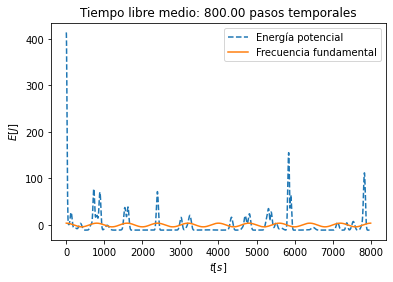

In [25]:
plt.plot(E_m, '--', label='Energía potencial')
plt.plot(np.real(fundamental), label='Frecuencia fundamental')
plt.xlabel(r'$t[s]$')
plt.ylabel(r'$E[J]$')
plt.title('Tiempo libre medio: {:.2f} pasos temporales'.format(1/f0))
plt.legend()
plt.show()

# Termodinámica

In [26]:
A=0.01
k=389.6
l=0.30
R = 8.3145
cv = 1.5*R
n = 1

In [27]:
C = k*A/(n*cv*l)

In [28]:
r0 = [400,200] #T10=400K, T20=200K
def f0(T1,T2,C):
    return -C*(T1-T2)

def f1(T1,T2,C):
    return C*(T1-T2)

In [29]:
def GetEuler(f0,f1,r0,t):
    
    h = (t[-1] - t[0])/(len(t)-1)
    
    T1 = np.zeros(len(t))
    T2 = np.zeros(len(t))
    
    T1[0] = r0[0]
    T2[0] = r0[1]
    
    K1 = np.zeros(2)
    
    for i in range( 1, len(t) ):
        
        K1[0] = f0(T1[i-1],T2[i-1],C)
        K1[1] = f1(T1[i-1],T2[i-1],C)
        
        T1[i] = T1[i-1] + h*K1[0]
        T2[i] = T2[i-1] + h*K1[1]
        
    return T1,T2

In [30]:
N = 50
t = np.linspace(0.,15.,N)

T1,T2 = GetEuler(f0,f1,r0,t)

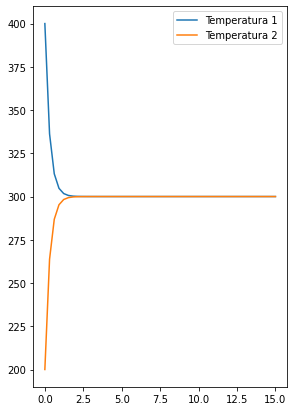

In [31]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(121)
ax.plot(t,T1, label='Temperatura 1')
ax.plot(t,T2, label='Temperatura 2')
ax.legend()